# FMA - What to Play Next? - Content-based filtering Recommendation

In [7]:
import time
import os

import IPython.display as ipd
from IPython.display import *
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
import utils
pd.options.mode.chained_assignment = None 

import matplotlib.pyplot as plt
from sklearn import model_selection

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
## This is just to make plots appear in the notebook
#%matplotlib inline

from sklearn.manifold import TSNE
import time
import seaborn as sns
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity

In [8]:
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = "4" #please put your GPU

In [9]:
tracks = utils.load('../data/tracks.csv')
features = utils.load('../data/features.csv')
echonest = utils.load('../data/echonest.csv')
genres = utils.load('../data/genres.csv')

tracks.shape, features.shape, echonest.shape, genres.shape

((106574, 52), (106574, 518), (13129, 249), (163, 4))

In [10]:
# !ls /aml/notebook/audio/fma_small/153
# Audio("/aml/notebook/audio/fma_small/153/153955.mp3", autoplay=True)

# Preprocessing

In [11]:
def preprocess(df):
    # Add genre_top, split, subset from track to features
    df_tracks = tracks
    genre_top = df_tracks.track.genre_top
    split = df_tracks.set.split
    subset = df_tracks.set.subset
    df = pd.concat([df, genre_top, split, subset], axis=1)
    df = df.dropna(subset=['genre_top'])
    
    # Remove genres with less than 1000 entries
    counts = df['genre_top'].value_counts()
    df = df[~df['genre_top'].isin(counts[counts < 1000].index)]
    df.genre_top.unique()
    return df


# Function that get recommendations based on the cosine similarity score of tracks
def get_recommender(idx, df, top_n = 5):
    sim_idx    = indices[idx]
    sim_scores = list(enumerate(cosine_sim[sim_idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    idx_rec    = [i[0] for i in sim_scores]
    idx_sim    = [i[1] for i in sim_scores]
    
    return indices.iloc[idx_rec].index, idx_sim

In [12]:
df_processed = preprocess(features)
df_small = df_processed[df_processed.subset == 'small']

X = df_small.drop(columns=['genre_top', 'split', 'subset'])
y = df_small['genre_top']
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y)

indices = pd.Series(range(len(df_small)), index=df_small.index)

# Recommendation

Dimensionality Reduction — it is a more efficient representation<br>
Contextual Similarity — it is a more expressive representation

#### All genres

t-SNE done! Time elapsed: 33.225942850112915 seconds


<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

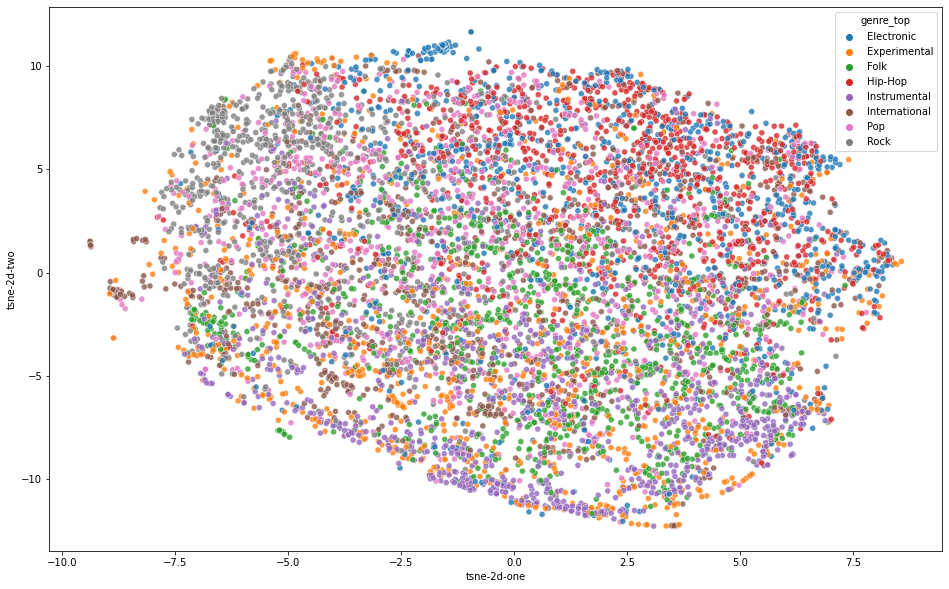

In [13]:
genres = ['Hip-Hop', 'Pop', 'Rock', 'Experimental', 'Folk', 'Electronic', 'International', 'Classical', 'Instrumental']

df_processed = preprocess(features)
df_small = df_processed[df_processed.subset == 'small']
df_small = df_small[df_small.genre_top.isin(genres)]
df_small["genre_top"].cat.remove_unused_categories(inplace=True)

df_embed = df_small.filter(regex='mfcc')
#df_embed = df_small.drop(columns=['genre_top', 'split', 'subset'])

cosine_sim = 1-pairwise_distances(df_embed, metric='cosine')
get_recommender(5, df_embed, top_n = 5)

time_start = time.time()
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df_embed)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

df_small['tsne-2d-one'] = tsne_results[:,0]
df_small['tsne-2d-two'] = tsne_results[:,1]

plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue="genre_top",
                data=df_small,
                legend="full",
                alpha=0.8)

#### 4 genres

t-SNE done! Time elapsed: 27.36181116104126 seconds


<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

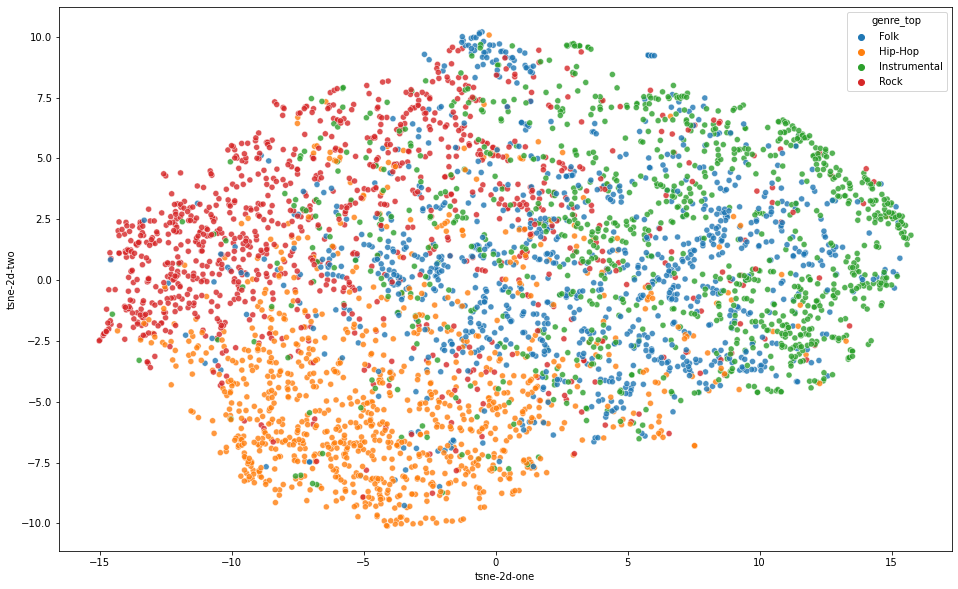

In [14]:
#genres = ['Hip-Hop', 'Pop', 'Rock', 'Experimental', 'Folk', 'Electronic', 'International', 'Classical', 'Instrumental']
genres = ['Hip-Hop', 'Folk', 'Instrumental', 'Rock']
df_processed = preprocess(features)
df_small = df_processed[df_processed.subset == 'small']
df_small = df_small[df_small.genre_top.isin(genres)]
df_small["genre_top"].cat.remove_unused_categories(inplace=True)
df_embed = df_small.filter(regex='mfcc')

#Get reccomendation based on cosine similarities
cosine_sim = 1-pairwise_distances(df_embed, metric='cosine')
get_recommender(5, df_embed, top_n = 5)

time_start = time.time()
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df_embed)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

df_small['tsne-2d-one'] = tsne_results[:,0]
df_small['tsne-2d-two'] = tsne_results[:,1]

plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue="genre_top",
                data=df_small,
                legend="full",
                alpha=0.8)

#### 4 genres w 1st 100 labels

<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

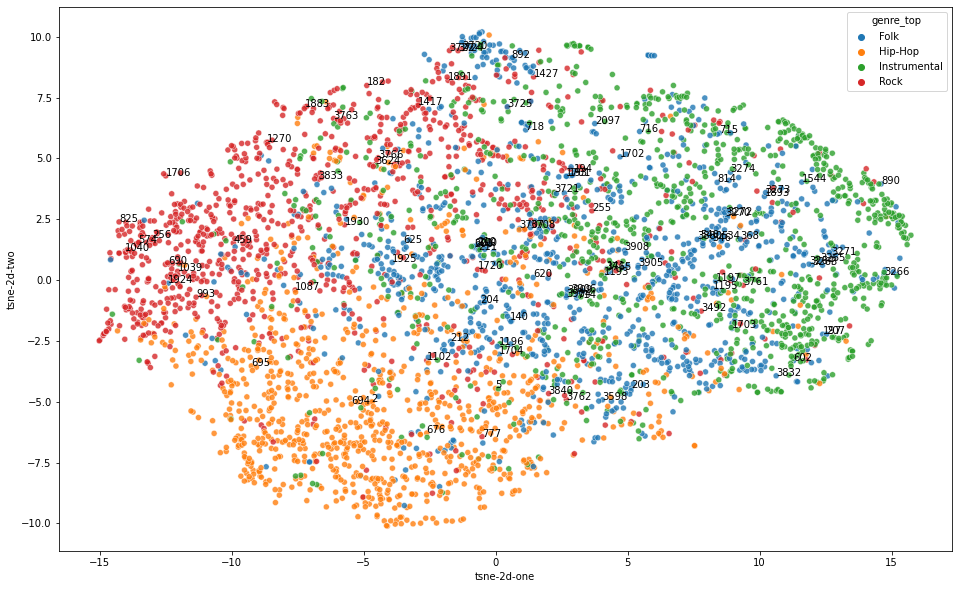

In [15]:
plt.figure(figsize=(16,10))
for i in range(100):
     track_id = df_small.index[i]
     plt.text(df_small[df_small.index == track_id]['tsne-2d-one'], 
              df_small[df_small.index == track_id]['tsne-2d-two'], 
              df_small.index[i], 
              fontdict=dict(color='black',size=10))
    
    
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue="genre_top",
                data=df_small,
                legend="full",
                alpha=0.8)

#### 4 genres using echonest features

t-SNE done! Time elapsed: 18.51737356185913 seconds


<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

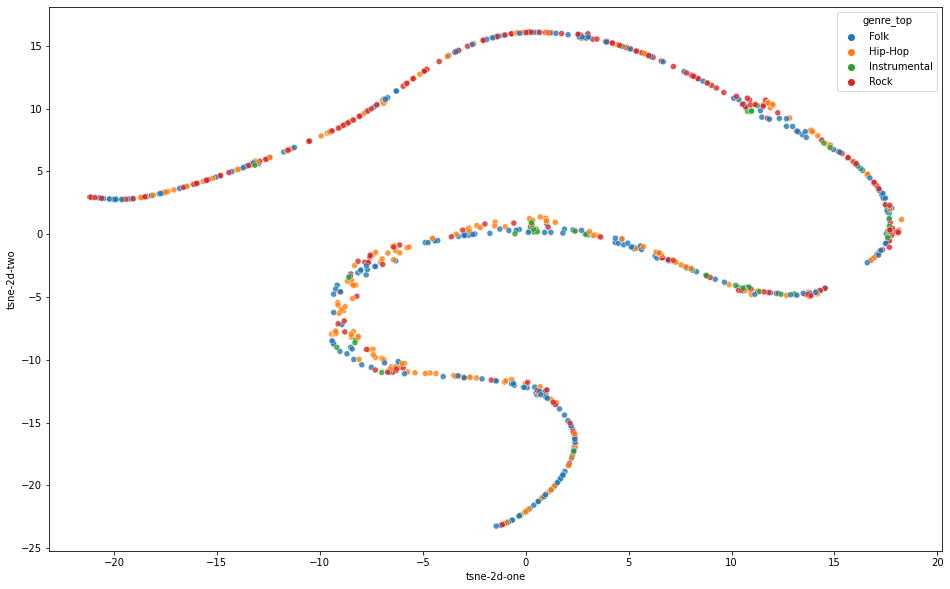

In [20]:
genres = ['Hip-Hop', 'Folk', 'Instrumental', 'Rock']
df_echonest = echonest.filter(regex='audio_features')
df_echonest = preprocess(df_echonest)

df_small_echonest = df_echonest[df_echonest.subset == 'small']
df_small_echonest = df_small_echonest.dropna()
df_small_echonest = df_small_echonest[df_small_echonest.genre_top.isin(genres)]
df_small_echonest["genre_top"].cat.remove_unused_categories(inplace=True)
df_embed = df_small_echonest.drop(columns=['genre_top', 'split', 'subset'])

cosine_sim = 1-pairwise_distances(df_embed, metric='cosine')
get_recommender(5, df_embed, top_n = 5)
time_start = time.time()
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df_embed)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

df_small_echonest['tsne-2d-one'] = tsne_results[:,0]
df_small_echonest['tsne-2d-two'] = tsne_results[:,1]

plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue="genre_top",
                data=df_small_echonest,
                legend="full",
                alpha=0.8)

In [243]:
# Function that get recommendations based on the cosine similarity score of tracks
def cosine_sim_func(idx, df, top_n = 5):
    sim_idx    = indices[idx]
    sim_scores = list(enumerate(cosine_sim[sim_idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    idx_rec    = [i[0] for i in sim_scores]
    idx_sim    = [i[1] for i in sim_scores]
    
    return indices.iloc[idx_rec].index, idx_sim

#### 1 Sample Recommendation based on cosine similarities. They appear close to each other in the plot

<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

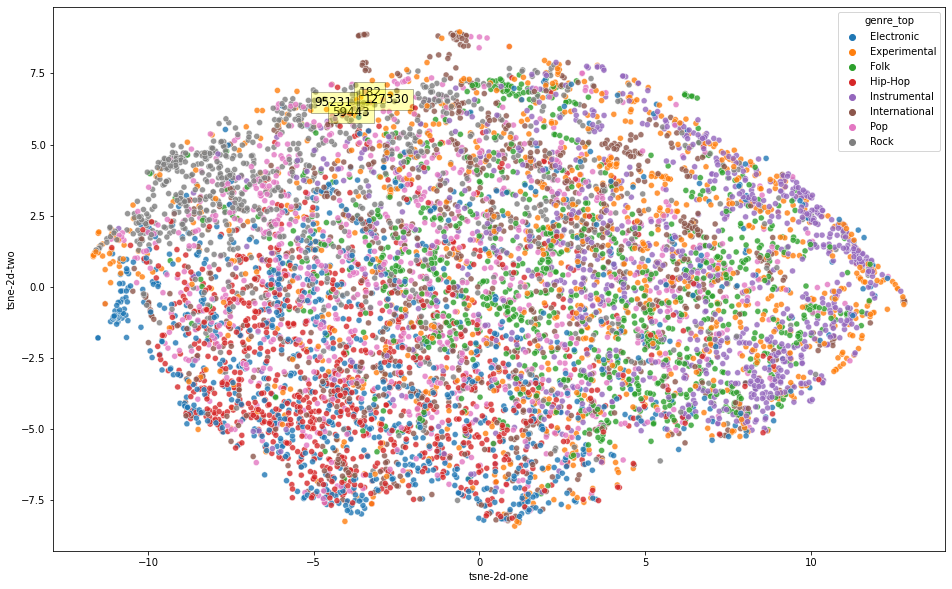

In [237]:
plt.figure(figsize=(16,10))
scope = [182, 127330, 95231, 59443]
for i in range(df_small.shape[0]):
     track_id = df_small.index[i]
     if track_id in scope:
         #print(track_id)
         plt.text(df_small[df_small.index == track_id]['tsne-2d-one'], 
                  df_small[df_small.index == track_id]['tsne-2d-two'], 
                  df_small.index[i], 
                  fontdict=dict(color='black',size=12),
                  bbox=dict(facecolor='yellow',alpha=0.3))
    
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue="genre_top",
                data=df_small,
                legend="full",
                alpha=0.8)

#### 4 genres again. It does not always return same plot

t-SNE done! Time elapsed: 3.606813669204712 seconds


<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

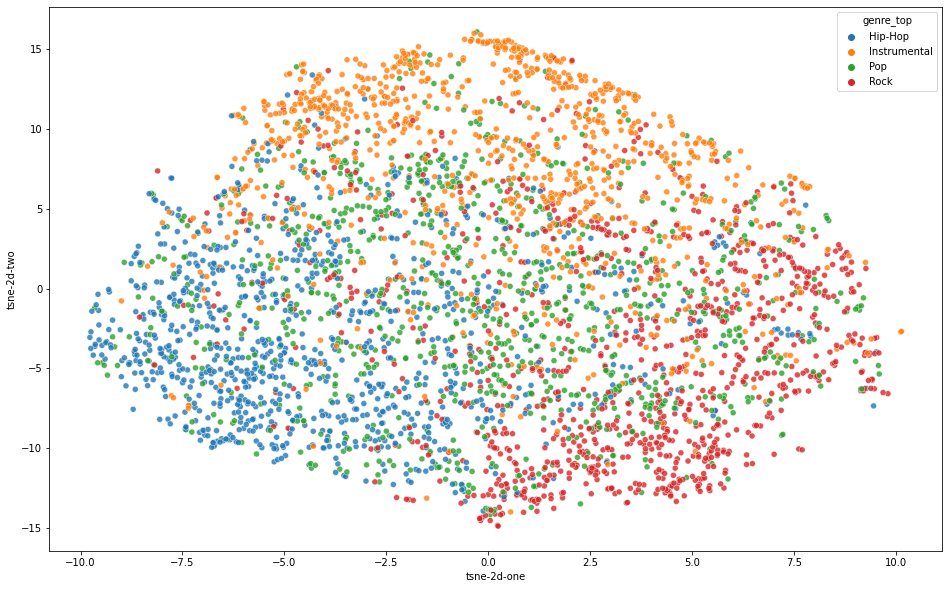

In [209]:
#genres = ['Hip-Hop', 'Pop', 'Rock', 'Experimental', 'Folk', 'Electronic', 'International', 'Classical', 'Instrumental']
genres = ['Hip-Hop', 'Pop', 'Instrumental', 'Rock']
df_processed = preprocess(features)
df_small = df_processed[df_processed.subset == 'small']
df_small = df_small[df_small.genre_top.isin(genres)]
df_small["genre_top"].cat.remove_unused_categories(inplace=True)
df_embed = df_small.filter(regex='mfcc')

#Get reccomendation based on cosine similarities
cosine_sim = 1-pairwise_distances(df_embed, metric='cosine')
get_recommender(5, df_embed, top_n = 5)

time_start = time.time()
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df_embed)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

df_small['tsne-2d-one'] = tsne_results[:,0]
df_small['tsne-2d-two'] = tsne_results[:,1]

plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue="genre_top",
                data=df_small,
                legend="full",
                alpha=0.8)

### Recommendation for 2 samples

In [160]:
selected_track = 148286
recommended, score = cosine_sim_func(selected_track, df_embed, top_n = 3)
print('selected track:', selected_track)
print('recommended:', recommended)
print('similarity score:', score)

selected track: 148286
recommended: Int64Index([13378, 148290, 13561], dtype='int64', name='track_id')
embedded score: [0.9964983391814762, 0.9952479194077009, 0.994991416169487]


In [162]:
df_small[df_small.index.isin([148286, 13378, 148290, 13561])].genre_top

track_id
13378         Pop
13561     Hip-Hop
148286        Pop
148290        Pop
Name: genre_top, dtype: category
Categories (8, object): ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']

In [270]:
selected_track = 182    
recommended, score = cosine_sim_func(selected_track, df_embed, top_n = 3)
print('selected track:', selected_track)
print('recommended:', recommended)
print('similarity score:', score)

46
selected track: 182
recommended: Int64Index([143282, 113556, 1369], dtype='int64', name='track_id')
similarity score: [0.9876702440310815, 0.9875804566813119, 0.9875029266433758]


In [158]:
df_small[df_small.index.isin([182, 127330, 95231, 59443])].genre_top

track_id
182       Rock
59443      Pop
95231     Rock
127330    Rock
Name: genre_top, dtype: category
Categories (8, object): ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']

In [154]:
Audio("/aml/notebook/audio/fma_small/000/000182.mp3", autoplay=True)
Audio("/aml/notebook/audio/fma_small/127/127330.mp3", autoplay=True)
Audio("/aml/notebook/audio/fma_small/095/095231.mp3", autoplay=True)
Audio("/aml/notebook/audio/fma_small/059/059443.mp3", autoplay=True)

In [269]:
Audio("/aml/notebook/audio/fma_small/148/148286.mp3", autoplay=True)
Audio("/aml/notebook/audio/fma_small/013/013378.mp3", autoplay=True)
Audio("/aml/notebook/audio/fma_small/148/148290.mp3", autoplay=True)
Audio("/aml/notebook/audio/fma_small/013/013561.mp3", autoplay=True)

#### 2 Sample Recommendation based on cosine similarities. They appear close to each other in the plot

182
13378
13561
59443
95231
127330
148286
148290


<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

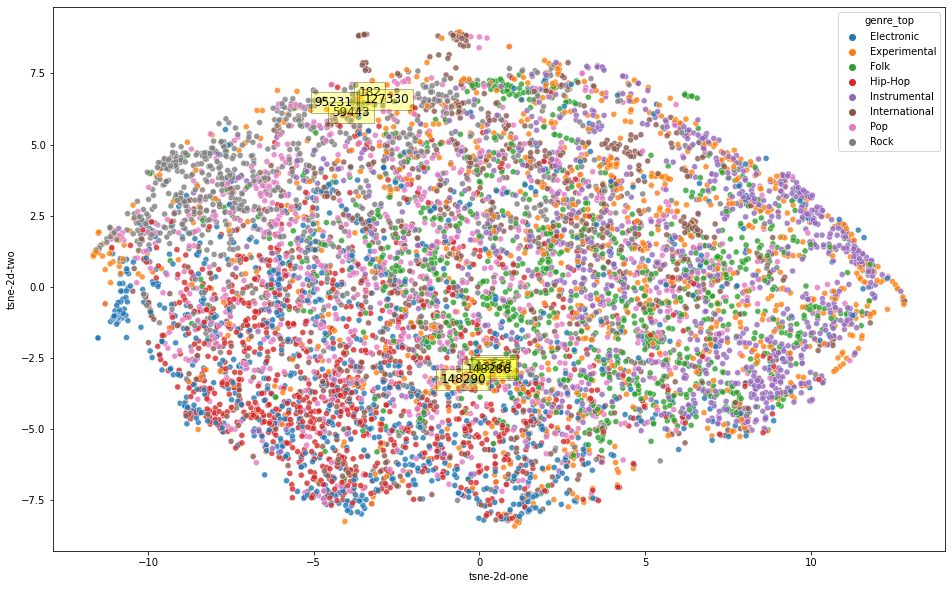

In [271]:
plt.figure(figsize=(16,10))
scope = [182, 127330, 95231, 59443, 148286, 13378, 148290, 13561]
for i in range(df_small.shape[0]):
     track_id = df_small.index[i]
     if track_id in scope:
         print(track_id)
         plt.text(df_small[df_small.index == track_id]['tsne-2d-one'], 
                  df_small[df_small.index == track_id]['tsne-2d-two'], 
                  df_small.index[i], 
                  fontdict=dict(color='black',size=12),
                  bbox=dict(facecolor='yellow',alpha=0.3))
    
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue="genre_top",
                data=df_small,
                legend="full",
                alpha=0.8)

#### Full dataset. Unfortunately, audio files of over 100k songs is too huge, so even after recommendation, we are not able to listen to those track

t-SNE done! Time elapsed: 87.784677028656 seconds


<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

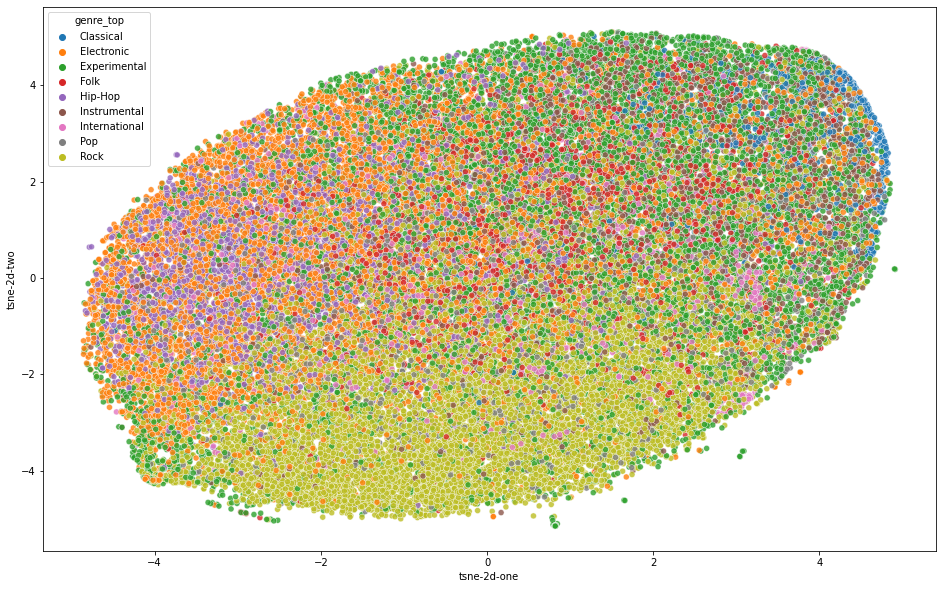

In [252]:
genres = ['Hip-Hop', 'Pop', 'Rock', 'Experimental', 'Folk', 'Electronic', 'International', 'Classical', 'Instrumental']

df_processed = preprocess(features)
#df_small = df_processed[df_processed.subset == 'small']
df = df_processed
df = df[df.genre_top.isin(genres)]
df["genre_top"].cat.remove_unused_categories(inplace=True)

df_embed = df.filter(regex='mfcc')
#df_embed = df_small.drop(columns=['genre_top', 'split', 'subset'])

cosine_sim = 1-pairwise_distances(df_embed, metric='cosine')
#get_recommender(5, df_embed, top_n = 5)

time_start = time.time()
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df_embed)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]

plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue="genre_top",
                data=df,
                legend="full",
                alpha=0.8)

In [263]:
cosine_sim = 1-pairwise_distances(df_embed, metric='cosine')
indices = pd.Series(range(len(df)), index=df.index)

selected_track = 182    
recommended, score = cosine_sim_func(selected_track, df_embed, top_n = 3)
print('selected track:', selected_track)
print('recommended:', recommended)
print('similarity score:', score)

46
selected track: 182
recommended: Int64Index([143282, 113556, 1369], dtype='int64', name='track_id')
similarity score: [0.9876702440310815, 0.9875804566813119, 0.9875029266433758]
